# ChordGAN

This notebook aims to replicate the work done to create `chordGAN` but using TF 2 instead, since the other version is old and deprecated

In [27]:
import pretty_midi
import reverse_pianoroll
import convert
import librosa

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
from datetime import datetime
from functools import reduce

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Concatenate
from keras.initializers import GlorotNormal
from keras.activations import sigmoid
from keras.losses import Loss

%load_ext lab_black
%load_ext tensorboard


# python script, in github repo
print("TF version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Numpy version:", np.__version__)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
TF version: 2.6.0
Keras version: 2.6.0
Numpy version: 1.21.2


Use the following to avoid GPU errors (if needed)

In [2]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)

## Setup helper functions

In [3]:
# add songs to data
def get_songs(path):
    files = glob.glob("{}/*.mid*".format(path))
    songs = []
    fnames = []
    for f in files:
        try:
            data = pretty_midi.PrettyMIDI(f)
            song = data.get_piano_roll(fs=16)
            song = convert.forward(song)
            # song = np.transpose(song) - if your code matrices aren't working, try uncommenting this. the convert.py file might not be updated
            songs.append(song)
            fnames.append(f)
        except Exception as e:
            raise e
    return songs, fnames


# custom function to extract chroma features from song
def get_chromas(songs, chroma_dims=12, n_notes=78):
    """
    chroma_dims : int
        The dimension of the chromas (12 notes in an equal tempered scale)
    n_notes : int
        The number of notes in the MIDI format
    """
    chromas = []
    for song in songs:
        chroma = np.zeros(shape=(song.shape[0], chroma_dims))  # 12 chroma values
        for i in np.arange(song.shape[0]):
            for j in np.arange(n_notes):
                if song[i][j] > 0:
                    chroma[i][np.mod(j, chroma_dims)] += 1
        # print(np.shape(chroma))
        chromas.append(chroma)

    return chromas

## Load data

In [4]:
fpath = "../data/chordGan/Pop/Pop_Music_Midi"
genre = fpath.split("/")[-1]

songs, _ = get_songs(fpath)
chromas = get_chromas(songs)
print("{} songs processed".format(len(songs)))
print("{} songs processed".format(len(chromas)))

C:\Users\gamin\anaconda3\envs\chordgan\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


122 songs processed
122 songs processed


In [117]:
ds = tf.data.Dataset.from_tensor_slices(
    [tf.RaggedTensor.from_tensor(song) for song in songs]
)

ValueError: TypeError: object of type 'RaggedTensor' has no len()


Let's peek at the chromas

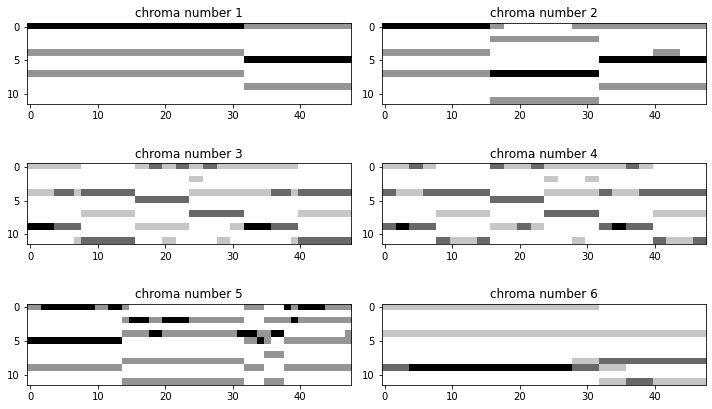

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

for i, (chroma, ax) in enumerate(zip(chromas[:10], axes.flatten())):
    ax.set_title(f"chroma number {i+1}")
    ax.imshow(chroma[:48].T, cmap="Greys")
plt.tight_layout()
plt.show()

## Setup GAN model

Note:

The discriminator has both the song timeseries and the chromagram as inputs, hence the two-dimensional inputs!

In [6]:
from src.model import ChordGAN

low_note, high_note = 0, 78  # The index of lowest/highest note on the piano roll
note_range = high_note - low_note

n_timesteps = 4  # This is the number of timesteps that we will create at a time
X_dim = 2 * note_range * n_timesteps  # This is the size of the visible layer.
Z_dim = 12 * n_timesteps

cgan = ChordGAN(X_dim, Z_dim)
cgan.compile(keras.optimizers.Adam(), keras.optimizers.Adam())

Test the generator

(1, 64, 624)


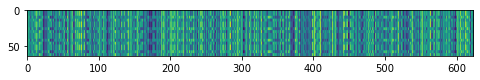

In [8]:
sample_timesteps = songs[0].shape[0] // n_timesteps
sample_chroma = chromas[0][: sample_timesteps * n_timesteps]
sample_chroma = sample_chroma.reshape(
    sample_timesteps, sample_chroma.shape[1] * n_timesteps
)
sample_out = cgan.generator(sample_chroma[tf.newaxis, ...])

print(sample_out.shape)
plt.figure(figsize=(8, 6))
plt.imshow(sample_out[0])
plt.show()

Test the discriminator

In [9]:
sample_song = songs[0][: sample_timesteps * n_timesteps]
sample_song = sample_song.reshape(
    [sample_timesteps, sample_song.shape[1] * n_timesteps]
)

sample_logits, sample_probas = cgan.discriminator(
    [sample_song[tf.newaxis, ...], sample_chroma[tf.newaxis, ...]]
)
print(
    f"Probability this is a true song, not a generated song: {tf.reduce_mean(sample_probas).numpy():.2%} "
)

Probability this is a true song, not a generated song: 46.27% 


# Training

We define a training step that will propagate the gradients for both generator and discriminator

In [40]:
reshaped_songs = []
reshaped_chromas = []

for (song, chroma) in zip(songs, chromas):
    song_timesteps = song.shape[0] // n_timesteps
    song = song[: song_timesteps * n_timesteps]  # discard any extra timesteps
    song = song.reshape([song_timesteps, song.shape[1] * n_timesteps])
    ragged_song = 
    reshaped_songs.append(song)

    # Similar process for the chroma
    # print("initial chroma shape", chroma.shape)
    chroma = chroma[: song_timesteps * n_timesteps]
    chroma = chroma.reshape([song_timesteps, chroma.shape[1] * n_timesteps])
    reshaped_chromas.append(chroma)

In [105]:
tf.ragged.constant(reshaped_songs).shape

TensorShape([122, None, None])

In [98]:
# def matrix_to_feat_matrix(matrix):
#     return FeatureList(
#         feature=[Feature(float_list=FloatList(value=row)) for row in matrix]
#     )


# from tensorflow.train import (
#     Feature,
#     FeatureList,
#     FeatureLists,
#     Features,
#     Example,
#     FloatList,
#     SequenceExample,
# )

# feat_ds = FeatureLists(
#     feature_list={
#         "songs": FeatureList(
#             feature=[matrix_to_feat_matrix(song) for song in reshaped_songs]
#         ),
#         "chromas": FeatureList(
#             feature=[matrix_to_feat_matrix(chroma) for chroma in reshaped_chromas]
#         ),
#     }
# )
# feat_ds

In [22]:
cgan.fit(x=(reshaped_songs, reshaped_chromas), batch_size=10, epochs=5)

ValueError: Data cardinality is ambiguous:
  x sizes: 64, 96, 32, 32, 64, 32, 32, 64, 52, 16, 36, 16, 32, 32, 32, 32, 32, 32, 64, 16, 128, 64, 92, 16, 16, 40, 32, 64, 64, 80, 32, 32, 32, 64, 40, 32, 64, 24, 48, 64, 32, 32, 33, 32, 32, 36, 64, 64, 32, 36, 48, 64, 64, 32, 32, 32, 32, 32, 36, 64, 32, 64, 36, 80, 52, 30, 32, 32, 32, 47, 32, 32, 48, 32, 68, 44, 32, 20, 16, 16, 64, 36, 32, 32, 32, 32, 68, 36, 36, 64, 80, 72, 16, 64, 64, 64, 16, 16, 72, 36, 18, 64, 48, 128, 64, 32, 32, 31, 48, 31, 36, 56, 32, 16, 32, 36, 32, 48, 32, 16, 32, 46, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184, 256, 384, 128, 128, 256, 128, 128, 256, 208, 64, 144, 64, 128, 128, 128, 128, 128, 128, 256, 64, 512, 256, 368, 64, 64, 160, 128, 256, 256, 320, 128, 128, 128, 256, 160, 128, 256, 96, 192, 256, 128, 128, 132, 128, 128, 144, 256, 256, 128, 144, 192, 256, 256, 128, 128, 128, 128, 128, 144, 256, 128, 256, 144, 320, 208, 122, 128, 128, 128, 190, 128, 128, 192, 128, 272, 176, 128, 80, 64, 64, 256, 144, 128, 128, 128, 128, 272, 144, 144, 256, 320, 288, 64, 256, 256, 256, 64, 64, 288, 144, 74, 256, 192, 512, 256, 128, 128, 127, 192, 124, 144, 224, 128, 64, 128, 144, 128, 192, 128, 64, 128, 184
Make sure all arrays contain the same number of samples.

In [19]:
# Reshape song from song_timesteps x 2*note_range
# to n_timesteps x 2*note_range
# print("initial song shape", song.shape)
sample = songs[0]
print(sample.shape)
song_timesteps = sample.shape[0] // n_timesteps
sample = sample[: song_timesteps * n_timesteps]  # discard any extra timesteps
sample = sample.reshape([song_timesteps, sample.shape[1] * n_timesteps])
print(sample.shape)

(256, 156)
(64, 624)


In [ ]:
num_epochs = 500
batch_size = 10
logs_path = f"train_logs/base_chordgan/{genre}/"
writer = tf.summary.create_file_writer(logs_path)

print(f"Training for {num_epochs} epochs, each with {len(songs)} steps")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}", flush=True)
    for step, (song, chroma) in enumerate(zip(songs, chromas)):
        # Reshape song from song_timesteps x 2*note_range
        # to n_timesteps x 2*note_range
        # print("initial song shape", song.shape)
        song_timesteps = song.shape[0] // n_timesteps
        song = song[: song_timesteps * n_timesteps]  # discard any extra timesteps
        song = song.reshape([song_timesteps, song.shape[1] * n_timesteps])
        # print("  final song shape", song.shape)

        # Similar process for the chroma
        # print("initial chroma shape", chroma.shape)
        chroma = chroma[: song_timesteps * n_timesteps]
        chroma = chroma.reshape([song_timesteps, chroma.shape[1] * n_timesteps])
        # print("  final chroma shape", chroma.shape)

        # This is not really a batch size, it is actually splitting the songs
        # in timesteps of size `batch_size` and training the model on the
        # sequences
        for idx in range(0, len(song), batch_size):
            X = song[tf.newaxis, idx : idx + batch_size, ...]
            Z = chroma[tf.newaxis, idx : idx + batch_size, ...]
            # print(X.shape, Z.shape)
            loss_writer = writer if step == len(songs) - 1 else None
            train_step(X, Z, loss_writer=False, step=step)

        if step + 1 % 10 == 0:
            print(".", end="", flush=True)

Training for 500 epochs, each with 122 steps
Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Ep

In [ ]:
generator.save("trained_models/pop/generator/base_500e")
discriminator.save("trained_models/pop/discriminator/base_500e")

INFO:tensorflow:Assets written to: trained_models/pop/generator/base_500e\assets


INFO:tensorflow:Assets written to: trained_models/pop/generator/base_500e\assets


In [ ]:
gen_loaded = keras.models.load_model("trained_models/pop/generator/base_500e")

In [ ]:
gen_loaded

Crude comparison of an the original input

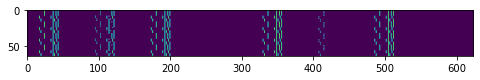

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(sample_song)
plt.show()

Against the generator output

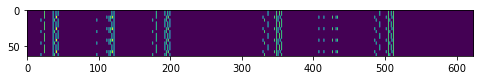

In [ ]:
out = generator(sample_chroma)

plt.figure(figsize=(8, 6))
plt.imshow(out)
plt.show()

In [ ]:
generator.call.get_concrete_function

AttributeError: 'function' object has no attribute 'get_concrete_function'

In [ ]:
out = gen_loaded(sample_chroma)

plt.figure(figsize=(8, 6))
plt.imshow(out)
plt.show()

ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * Tensor("inputs:0", shape=(64, 48), dtype=float32)
  Keyword arguments: {}

Expected these arguments to match one of the following 1 option(s):

Option 1:
  Positional arguments (1 total):
    * TensorSpec(shape=(None, None, 48), dtype=tf.float32, name='inputs')
  Keyword arguments: {}

Naturally it doesn't make sense to look at this as an image but it at least shows the result is close enough

# Style Transfer

In [ ]:
classical_songs, fpaths = get_songs("../data/chordGan/CLassical_Bach/bachpreludes")
classical_chromas = get_chromas(classical_songs)

C:\Users\gamin\anaconda3\envs\chordgan\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [ ]:
if not os.path.exists("converted/"):
    os.makedirs("converted/")

for idx, (c_chroma, fpath) in enumerate(zip(classical_chromas, fpaths)):
    # reshape
    song_timesteps = c_chroma.shape[0] // n_timesteps
    c_chroma = c_chroma[: song_timesteps * n_timesteps]
    c_chroma = c_chroma.reshape(song_timesteps, c_chroma.shape[1] * n_timesteps)

    converted_song = generator(c_chroma).numpy()
    S = converted_song.reshape(
        int(reduce(lambda x, y: x * y, converted_song.shape) / 2 / note_range),
        2 * note_range,
    )
    S_thresh = (S >= 0.5).T
    C = c_chroma.reshape(c_chroma.shape[0] * n_timesteps, 12)

    output = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(S_thresh), fs=16)
    fname = fpath.split("\\")[-1]
    output.write(f"converted/{fname}.mid")

In [ ]:
S.shape

(652, 156)